**Telecom churn prediction**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
 
**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);

- Выделенная линия технической поддержки (*TechSupport*);

- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);

- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

План:

1. [Загрузка и подготовка данных.](#start)

2. [Исследование данных.](#exploration)

3. [Построение модели без учета дисбаланса классов.](#disbalance)

4. [Построение модели с учетом дисбаланса классов.](#undisbalance)

5. [Финальное тестирование.](#auc-roc)

6. [Прогнозирование оттока действующих клиентов.](#predict)

7. [Вывод.](#conclusion)

8. [Отчет о проделанной работе.](#report)

In [1]:
!pip install --upgrade --user seaborn

Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


<a id="start"></a>
# 1. Подготовка данных.

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import itertools
import seaborn as sns; sns.set()
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from pandas.api.types import CategoricalDtype
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

In [3]:
df_contract=pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_personal=pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
df_phone=pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [6]:
df_internet=pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


объедним данные в одном датасете

In [7]:
df_1 = df_contract.merge(df_personal, how = 'outer', on='customerID')
df_2 = df_1.merge(df_internet, how = 'outer', on='customerID')
df_full = df_2.merge(df_phone, how = 'outer', on='customerID')

In [8]:
df_full.info()
df_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


посмотрим уникальные значений всех столбцов

In [9]:
for item in df_full.columns:
    print(item)
    print (df_full[item].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-

приведем все записи в датасете к нижнему регистру.

In [10]:
for item in df_full.columns:
    try:
        df_full[item] = df_full[item].str.lower()
    except:
        print(item, "невозможно преобразовать")
df_full.head()

MonthlyCharges невозможно преобразовать
SeniorCitizen невозможно преобразовать


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,1889.5,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-qpybk,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-hqitu,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,female,0,no,no,fiber optic,no,no,no,no,no,no,no


приведем к нижнему регистру названия признаков

In [11]:
df_full.columns = [x.lower() for x in df_full.columns]

посмотрим долю пропущенных значений в каждом столбце

In [12]:
for col in df_full.columns:
    missing_df = (df_full[col].isnull()).mean()
    print ('{} - {:.2f}%'.format(col, missing_df*100))

customerid - 0.00%
begindate - 0.00%
enddate - 0.00%
type - 0.00%
paperlessbilling - 0.00%
paymentmethod - 0.00%
monthlycharges - 0.00%
totalcharges - 0.00%
gender - 0.00%
seniorcitizen - 0.00%
partner - 0.00%
dependents - 0.00%
internetservice - 21.67%
onlinesecurity - 21.67%
onlinebackup - 21.67%
deviceprotection - 21.67%
techsupport - 21.67%
streamingtv - 21.67%
streamingmovies - 21.67%
multiplelines - 9.68%


In [13]:
df_full.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,1889.5,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-qpybk,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-hqitu,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,female,0,no,no,fiber optic,no,no,no,no,no,no,no


перевводим признаки к соответсвующим типам данных, а также создадим новые признаки, в том числе целевой признак churn, отражающий отток клиентов

In [14]:
df_full['churn'] = df_full['enddate'].apply(lambda x: '0' if x == 'no' else '1')

пропущенные значения в признаке с датам окончания действия договора заполним датой "01.02.2020", предполагая, что раньше клиенты не могли уйти

In [15]:
df_full['enddate'] = df_full['enddate'].replace({'no':'2020-02-01'})

In [16]:
df_full['begindate']= pd.to_datetime(df_full['begindate'])

In [17]:
df_full['enddate']= pd.to_datetime(df_full['enddate'], format="%Y/%m/%d", errors='coerce')

In [18]:
df_full['months_of_use'] = (df_full['enddate'] - df_full['begindate'])//np.timedelta64(1, 'M')

In [19]:
df_full.loc[df_full['totalcharges']==' ','totalcharges'] = np.nan

Преобразуем totalcharges в числовой тип данных, однако, так как в столбце имеются пустые записи, сперва мы конвертируем totalcharges в тип данных float, а затем заменим пустые занчения на ежемесячные платежи за пользование услугами нашей компании.

In [20]:
df_full['totalcharges'] = df_full['totalcharges'].astype('float64')
df_full.loc[df_full['totalcharges'].isnull()==True,'totalcharges'] = df_full['monthlycharges'] * df_full['months_of_use']

In [21]:
df_full['multiplelines'] = df_full['multiplelines'].replace({np.nan:None})

In [22]:
df_full['phoneservice'] = df_full['multiplelines'].apply(lambda x: '0' if x ==None else '1')

In [23]:
df_full['internetservice'] = df_full['internetservice'].replace({np.nan:'no_internet_service'})

In [24]:
df_full[['onlinesecurity', 'onlinebackup', 'deviceprotection',\
         'techsupport', 'streamingtv', 'streamingmovies']] = \
df_full[['onlinesecurity', 'onlinebackup', 'deviceprotection',\
         'techsupport', 'streamingtv', 'streamingmovies']].replace({np.nan:'no_internet_service'})

In [25]:
df_full['multiplelines'] = df_full['multiplelines'].replace({np.nan:'no_phone_service'})

In [26]:
df_full['months_of_use'] = df_full['months_of_use'].astype('Int64')

In [27]:
df_full['seniorcitizen']= df_full['seniorcitizen'].astype(object)

In [28]:
 df_full.rename(columns={'type':'contract_type'},inplace=True)

удаляем признаки, которые могут помешать корректной работе модели либо наличие которых не влияет на конечный результат

In [29]:
df_full.drop(['customerid', 'begindate', 'enddate'], axis=1, inplace=True)

In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
contract_type       7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
gender              7043 non-null object
seniorcitizen       7043 non-null object
partner             7043 non-null object
dependents          7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
multiplelines       7043 non-null object
churn               7043 non-null object
months_of_use       7043 non-null Int64
phoneservice        7043 non-null object
dtypes: Int64(1), float64(2), object(17)
memory usage: 1.1+ MB


In [31]:
for col in df_full.columns:
    missing_df = (df_full[col].isnull()).mean()
    print ('{} - {:.2f}%'.format(col, missing_df*100))

contract_type - 0.00%
paperlessbilling - 0.00%
paymentmethod - 0.00%
monthlycharges - 0.00%
totalcharges - 0.00%
gender - 0.00%
seniorcitizen - 0.00%
partner - 0.00%
dependents - 0.00%
internetservice - 0.00%
onlinesecurity - 0.00%
onlinebackup - 0.00%
deviceprotection - 0.00%
techsupport - 0.00%
streamingtv - 0.00%
streamingmovies - 0.00%
multiplelines - 0.00%
churn - 0.00%
months_of_use - 0.00%
phoneservice - 0.00%


In [32]:
df_full.head()

,contract_type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,months_of_use,phoneservice
0,month-to-month,yes,electronic check,29.85,29.85,female,0,yes,no,dsl,no,yes,no,no,no,no,no_phone_service,0,1,0
1,one year,no,mailed check,56.95,1889.50,male,0,no,no,dsl,yes,no,yes,no,no,no,no,0,34,1
2,month-to-month,yes,mailed check,53.85,108.15,male,0,no,no,dsl,yes,yes,no,no,no,no,no,1,2,1
3,one year,no,bank transfer (automatic),42.30,1840.75,male,0,no,no,dsl,yes,no,yes,yes,no,no,no_phone_service,0,45,0
4,month-to-month,yes,electronic check,70.70,151.65,female,0,no,no,fiber optic,no,no,no,no,no,no,no,1,2,1


In [33]:
df_full.describe()

,monthlycharges,totalcharges,months_of_use
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,32.166832
std,30.090047,2266.794470,24.529822
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,8.000000
50%,70.350000,1394.550000,29.000000
75%,89.850000,3786.600000,55.000000
max,118.750000,8684.800000,71.000000


На первом этапе мы посмотрели на наши исходные данные и подготовили их для дальнейшего исследования. Так, в частности, произведеные следующие действия:

- Для удобства дальнейшей работы с данными полученные 4 датасета, содержащие информацию о наших клиентах и их характеристиках, объединены в один датасет методом merge.

- Обнаружены проблемы с тимпами данных некоторых признаков, а именно totalcharges, даты начала и окончания действия договора с клиентом. Данные проблемы решены путем замены типа данных указанных признаков, при этом в признаке totalcharges также обнаружены строки с пустыми занчениями, которые заменены сумму общего дохода от клиента в зависимости от количества месяцев пользования и суммы месячного платежа.

- После объединения датасетов возникли пропущенные значения, которые заменены соответствующее числовое либо текстовое значение, указывающее на факт отсутствия той или иной услуги у клиента.

- Все значения столбцов, в том числе и названия столбцов, приведены к нижнему регистру во избежание проблем, связанных с опечатками.

- Созданы новые признаки, а именно признак (целевой) оттока клиентов churn, признак months_of_use, указывающий на количество месяцев пользования услугами нашей компании конкретным клиентом, а также признаки phoneservice и internetservice, указывающие на факт наличия либо отсутствия данных услуг у клиента.

- Удалены следующие признаки: 'customerid', 'begindate', 'enddate'. Первый признак удален, так как его необходимость для качественного обучения модели маловероятна, а последние 2 признака удалены, чтобы избежать утечки целевого признака.

<a id="exploration"></a>
# 2.Исследование данных

In [34]:
def bar_plot(variable):
    var = df_full[variable]
    varValue = var.value_counts(normalize=True)
    
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("count")
    plt.title(variable)
    plt.show()
    print("{}:\n{}".format(variable,varValue))

In [35]:
categorical = (df_full.dtypes == "object")
categorical_list = list(categorical[categorical].index)

In [36]:
print("categorical variables:")
print(categorical_list)

categorical variables:
['contract_type', 'paperlessbilling', 'paymentmethod', 'gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines', 'churn', 'phoneservice']


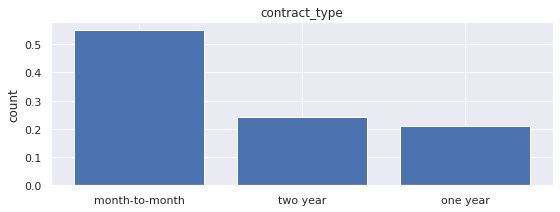

contract_type:
month-to-month    0.550192
two year          0.240664
one year          0.209144
Name: contract_type, dtype: float64


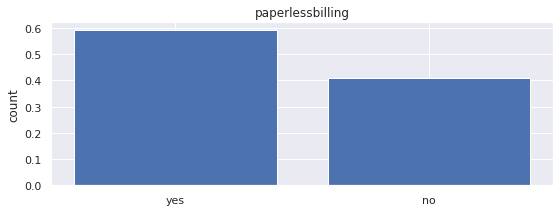

paperlessbilling:
yes    0.592219
no     0.407781
Name: paperlessbilling, dtype: float64


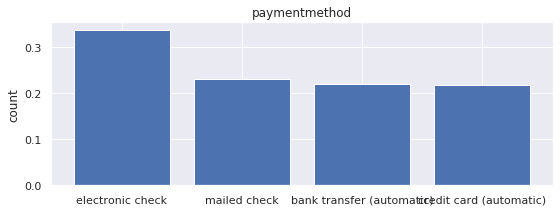

paymentmethod:
electronic check             0.335794
mailed check                 0.228880
bank transfer (automatic)    0.219225
credit card (automatic)      0.216101
Name: paymentmethod, dtype: float64


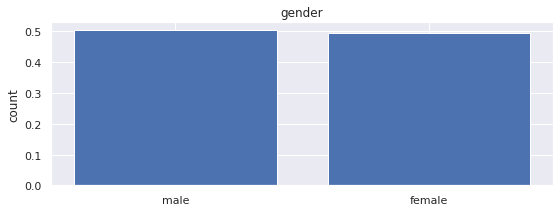

gender:
male      0.504756
female    0.495244
Name: gender, dtype: float64


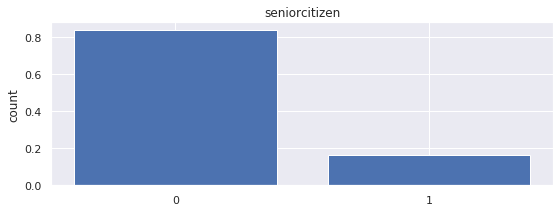

seniorcitizen:
0    0.837853
1    0.162147
Name: seniorcitizen, dtype: float64


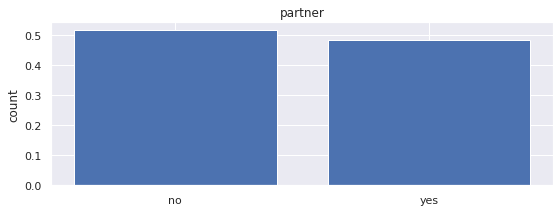

partner:
no     0.516967
yes    0.483033
Name: partner, dtype: float64


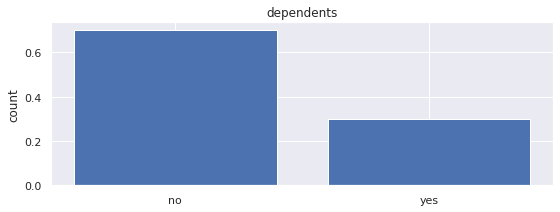

dependents:
no     0.700412
yes    0.299588
Name: dependents, dtype: float64


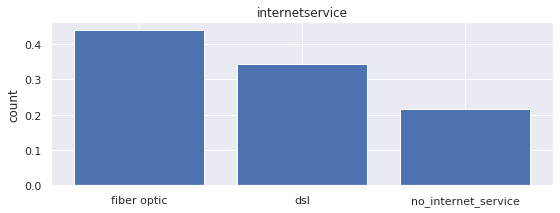

internetservice:
fiber optic            0.439585
dsl                    0.343746
no_internet_service    0.216669
Name: internetservice, dtype: float64


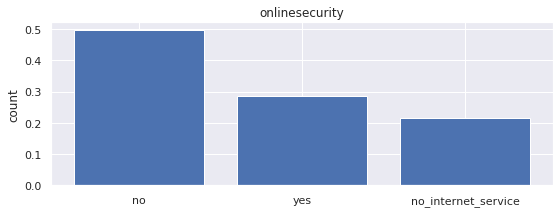

onlinesecurity:
no                     0.496663
yes                    0.286668
no_internet_service    0.216669
Name: onlinesecurity, dtype: float64


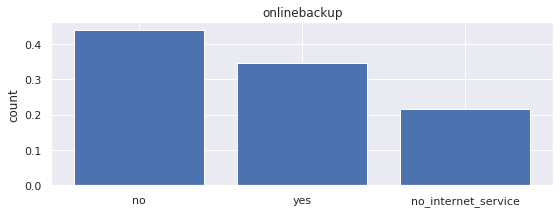

onlinebackup:
no                     0.438450
yes                    0.344881
no_internet_service    0.216669
Name: onlinebackup, dtype: float64


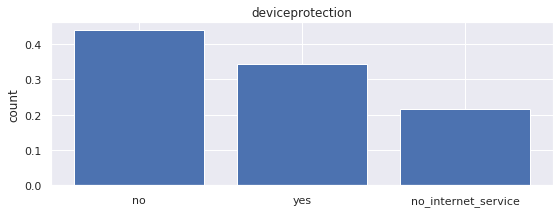

deviceprotection:
no                     0.439443
yes                    0.343888
no_internet_service    0.216669
Name: deviceprotection, dtype: float64


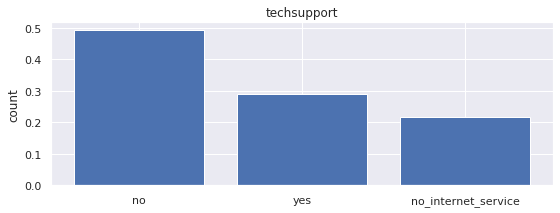

techsupport:
no                     0.493114
yes                    0.290217
no_internet_service    0.216669
Name: techsupport, dtype: float64


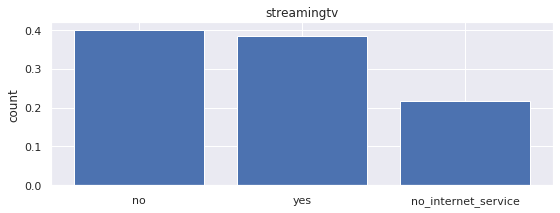

streamingtv:
no                     0.398978
yes                    0.384353
no_internet_service    0.216669
Name: streamingtv, dtype: float64


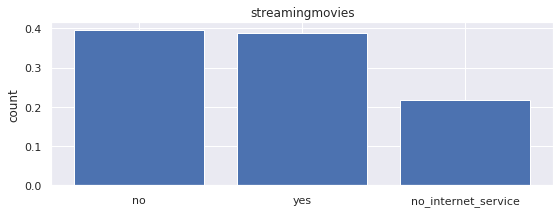

streamingmovies:
no                     0.395428
yes                    0.387903
no_internet_service    0.216669
Name: streamingmovies, dtype: float64


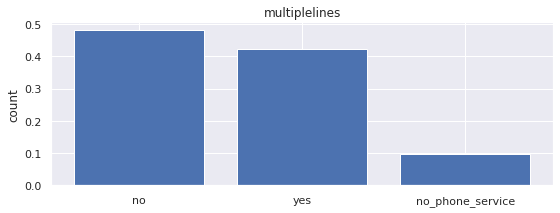

multiplelines:
no                  0.481329
yes                 0.421837
no_phone_service    0.096834
Name: multiplelines, dtype: float64


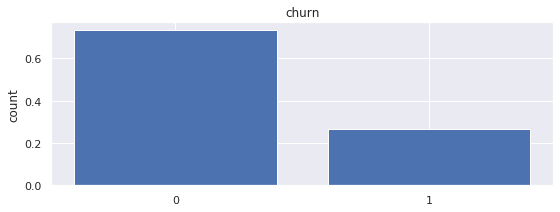

churn:
0    0.73463
1    0.26537
Name: churn, dtype: float64


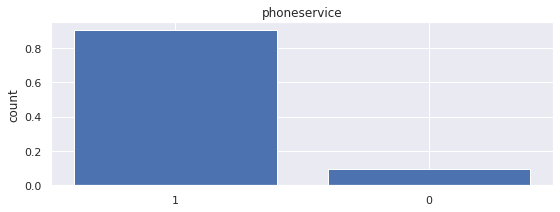

phoneservice:
1    0.903166
0    0.096834
Name: phoneservice, dtype: float64


In [37]:
for c in categorical_list:
    bar_plot(c)

Среди наблюдаемых распределений категориальных признаков нашего датасета особо следует выделить целевой признак churn. Соотношение количества оставшихся и ушедших клиентов практически 4:1 соответственно. Такое соотношение говорит о наличии дисбаланса классов, поэтому над этим моментом следует поработать.

Также мы видим, что подаваляющее большинство клиентов, а именно 90%, пользуются стационарной телефонной связью, при этом соотношение тех, кто подключил аппарат к нескольким линиям одновременно, и тех, кто не пользуется данной услугой, примерно одинаковое.

Пользователями интернет-сервисов нашей компании являются около 80% рассматриваемого списка клиентов, из которых большая часть использует оптоволоконный кабель.

Также, большая часть из пользователей интернета не используют такие дополнительные услуги, как: onlinesecurity, onlinebackup, techsupport, deviceprotection, при этом любители стримингового видеконтента и равнодушные к данному предложению разделились практически поровну.

Кроме того отметим, что подавляющее число клиентов младше пенсионного возраста, пожилых людей около 16%.

Также наблюдаем примерно одинаковое количество людей "семейных" и "одиноких" волков (волчиц).

Кроме того, около 70% наших рассматриваемвых клиентов не имеют иждивенцев, то есть без детей.

Соотношение полов примерно одинаковое.

Вместе с тем, отдельно стоит отметить соотношение количества клиентов, заключавших договоры каждый месяц, и тех, кто готов "серьезно" сотрудничать с нашей компаний, заключив договоры сразу на 1 или 2 года, разнится, первых на порядок больше, в частности их больше половины от всех клиентов.

Среди методов оплаты наиболее популярен метод оплаты с использованием электронного чека, остальные методы примерно одинаково популярны.

Сервис по дистанционному самообслуживанию достаточно популярен, таких пользователей 60% клиентов.

In [38]:
numerical_features = df_full.select_dtypes(include=[np.number]).columns
numerical_list = df_full[numerical_features].astype(bool)


print("numerical variables:")
print(numerical_list)

numerical variables:
      monthlycharges  totalcharges  months_of_use
0               True          True           True
1               True          True           True
2               True          True           True
3               True          True           True
4               True          True           True
...              ...           ...            ...
7038            True          True           True
7039            True          True           True
7040            True          True           True
7041            True          True           True
7042            True          True           True

[7043 rows x 3 columns]


In [39]:
def plot_hist(variable):
    plt.figure(figsize = (12,5))
    plt.hist(df_full[variable], bins = 70)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

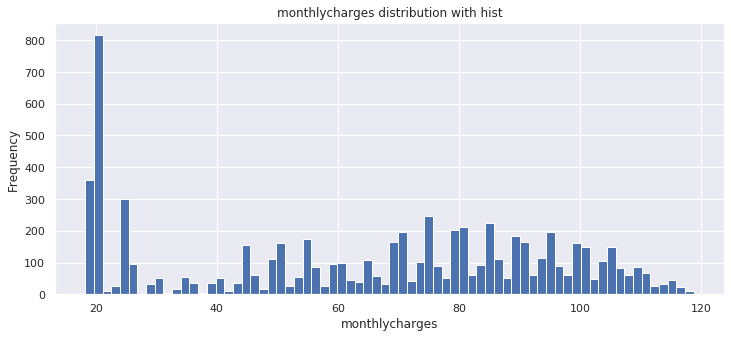

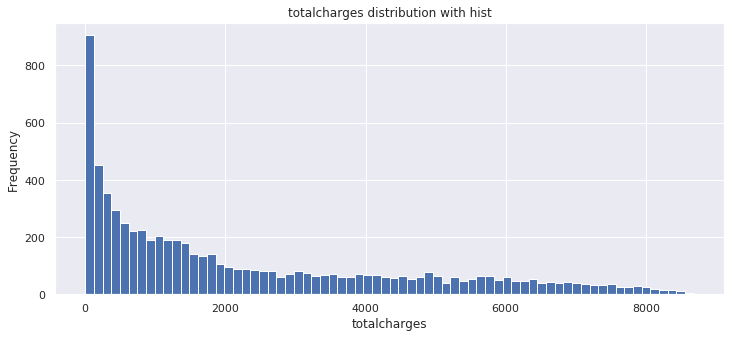

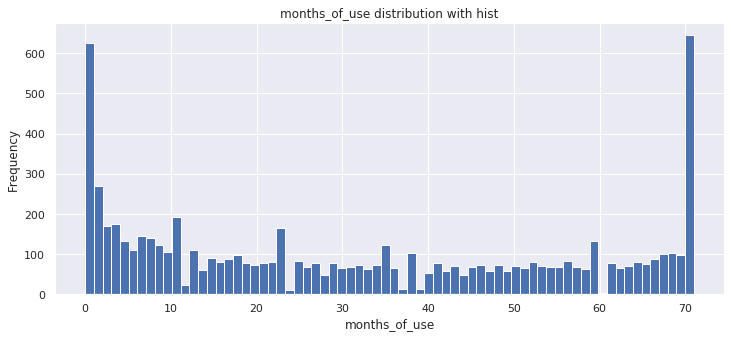

In [40]:
for n in numerical_list:
    plot_hist(n)

In [41]:
def outlier_boxplot(df, col):
    sns.boxplot(x=df_full[col])
    plt.show()

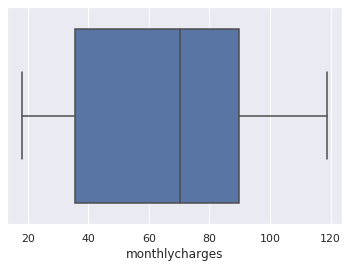

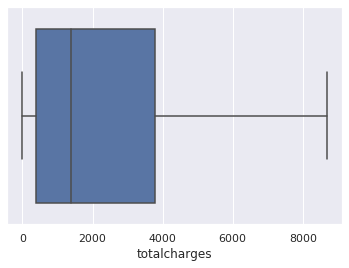

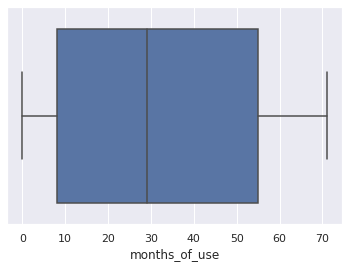

In [42]:
for n in numerical_list:
    outlier_boxplot(df_full,n)

Как видим, по числовым признакам выбросов не наблюдаем.

In [43]:
(pd.DataFrame(df_full[['monthlycharges', 'totalcharges', 'months_of_use']])).describe()

,monthlycharges,totalcharges,months_of_use
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,32.166832
std,30.090047,2266.794470,24.529822
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,8.000000
50%,70.350000,1394.550000,29.000000
75%,89.850000,3786.600000,55.000000
max,118.750000,8684.800000,71.000000


Как видим, среднестатистический клиент платит нашей компании почти 64 тугрика в месяц,  лоялен нам почти 3 года, не считая 4 месяцев, и, соответственно, в среднем приносит доход почти 2300 тугриков.

In [44]:
categorical_features = ["gender","partner","dependents","seniorcitizen","phoneservice","multiplelines"
                    ,"internetservice","onlinesecurity","onlinebackup","deviceprotection"
                    ,"techsupport","streamingtv","streamingmovies",
                    "contract_type","paperlessbilling","paymentmethod"]

In [45]:
def create_data_label(ax):
    for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/ 2
                    , bar.get_height() + 0.01
                    , str(round(100 * bar.get_height(),2)) + '%'
                    , ha = 'center'
                    , fontsize = 13)
            
            
def сategorical_var_churn_dist(df_full, cols, distribution_col):
    """ Распределение категориальных признаков """
    
    for i,feature in enumerate(cols):
        
        feature_summary = df_full[feature].value_counts(normalize=True).reset_index(name='Percentage')
        
        plt_cat = sns.catplot(x=feature
                , y='Percentage'
                , data = feature_summary
                , col=distribution_col
                , kind='bar'
                , aspect = 0.8
                , alpha = 0.6)
        
        if feature == 'PaymentMethod':
            plt_cat.set_xticklabels(rotation= 65, horizontalalignment = 'right')
        
        
        for ax1, ax2 in plt_cat.axes:
            create_data_label(ax1)
            create_data_label(ax2)
        
        
        plt.ylim(top=1)
        plt.subplots_adjust(top = 0.9)
        plt.gcf().suptitle(feature+" distribution",fontsize=14)
    plt.show()

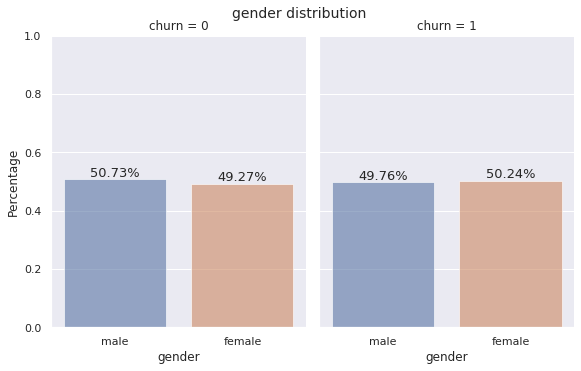

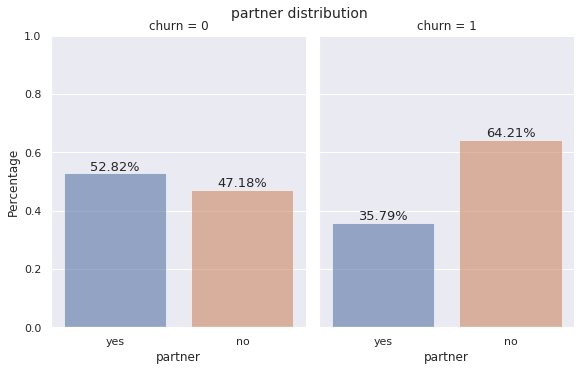

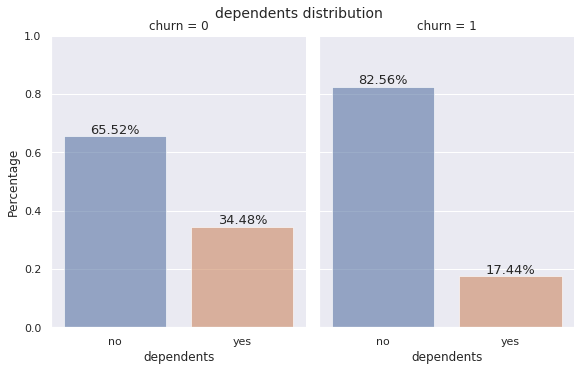

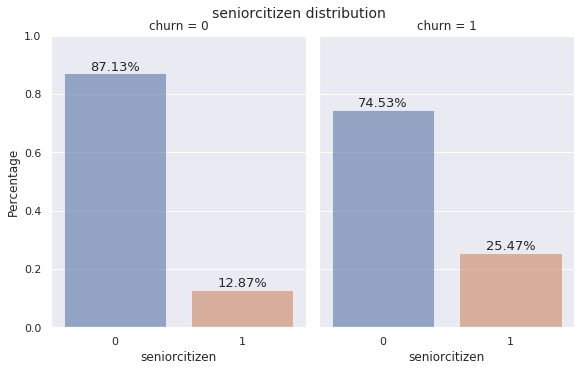

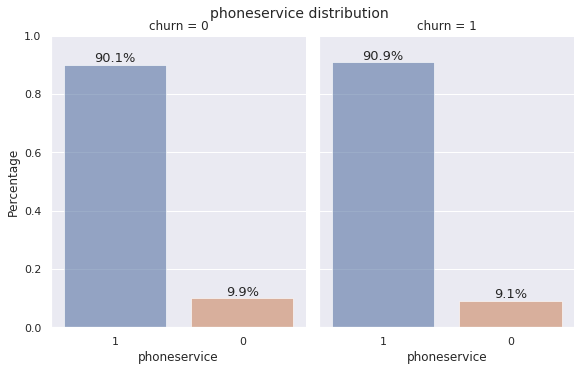

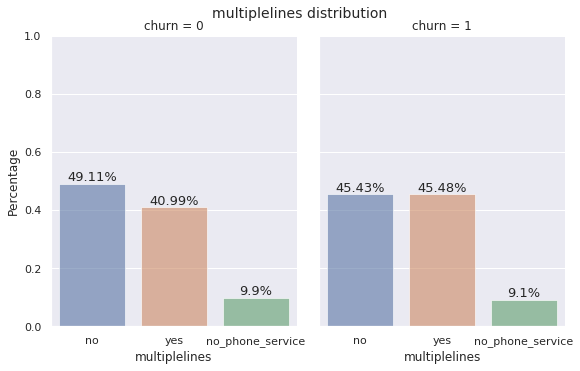

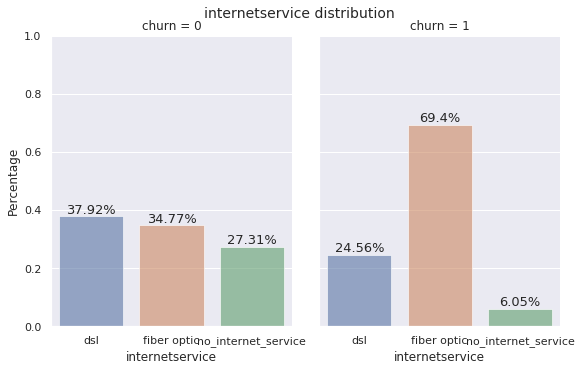

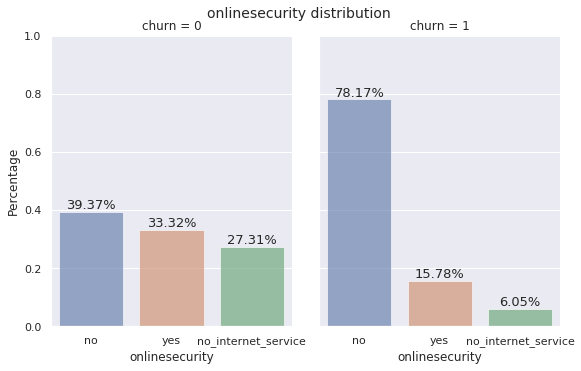

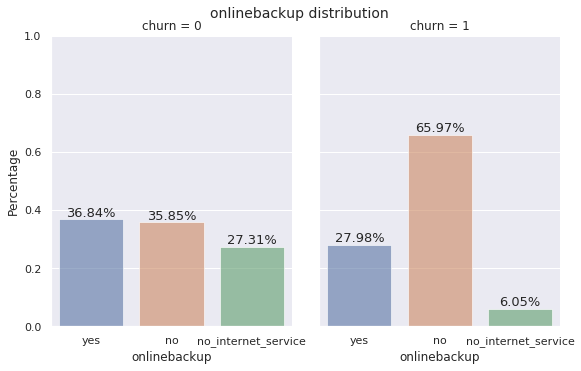

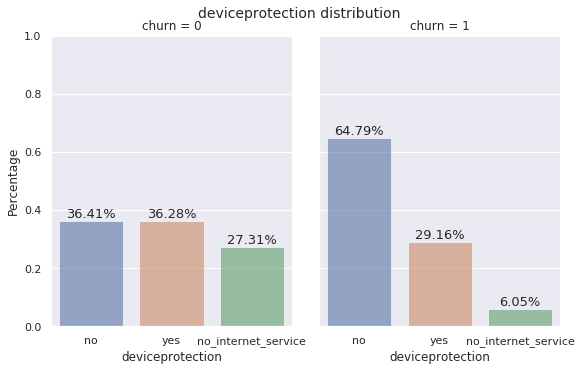

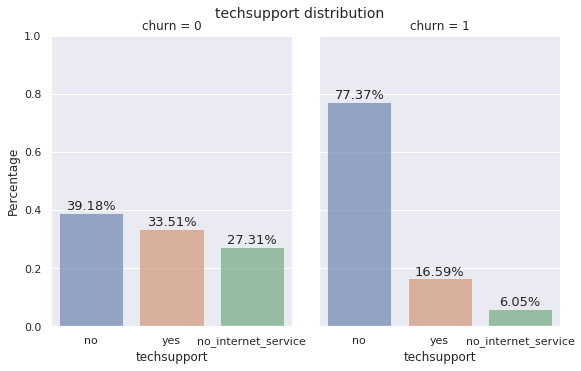

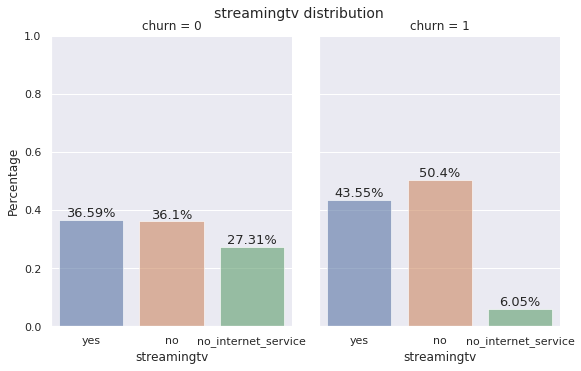

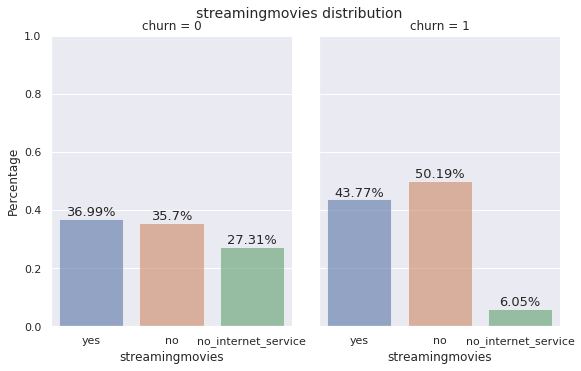

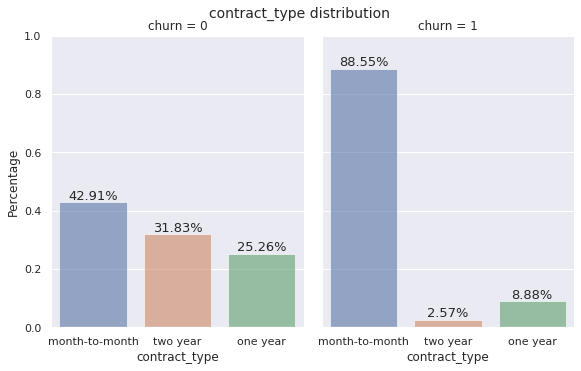

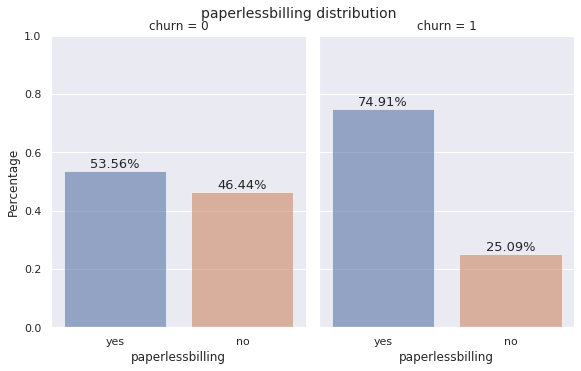

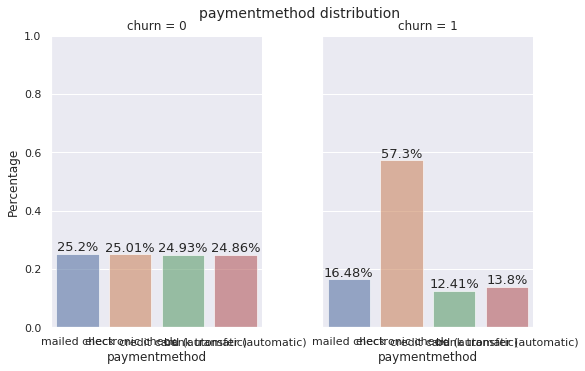

In [46]:
churn_summary = df_full.groupby('churn')
сategorical_var_churn_dist(churn_summary, categorical_features,'churn')

Для ушедших клиентов характерны следующие особенности:

1. отсутствие партнера и лиц на иждевении, то есть скорее всего это не связанные узами брака люди;

2. Это люди в большей части непенсинного возраста.

3. В большинстве своем пользователи интернет-сервиса, преимущественно посредством использования оптоволоконной сети.

4.  В основном эти люди не пользуются доп. услугами в рамках пользования интернет-сервисом, при этом все же среди данных лиц не мало тех, кто использует сервисы потокового видео.

5. Подаваляющее большинство таких клиентов не заключают долгосрочные контракты.

6. Предпочитают оплату путем использования электронного чека.

7. Значительная часть клиентов пользуется возможностями дистанционного управления своими услугами.

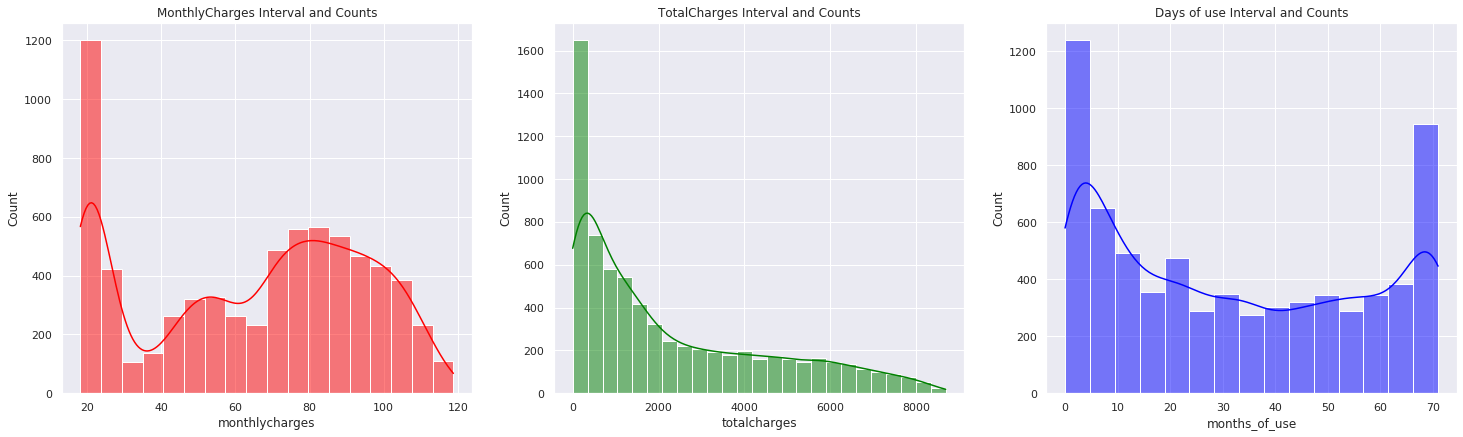

In [47]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
sns.histplot(df_full['monthlycharges'], color = 'red', kde = True).set_title('MonthlyCharges Interval and Counts')

plt.subplot(2,3,2)
sns.histplot(df_full['totalcharges'], color = 'green', kde = True).set_title('TotalCharges Interval and Counts')

plt.subplot(2,3,3)
sns.histplot(df_full['months_of_use'].astype(int),color = 'blue', kde = True).set_title('Days of use Interval and Counts');

In [48]:
print(churn_summary['months_of_use','monthlycharges','totalcharges'].mean())

       months_of_use  monthlycharges  totalcharges
churn                                             
0          37.433127       61.265124   2549.911442
1          17.588015       74.441332   1531.796094


Мы видим, что ушедшие клиенты  в среднем ежемесячно платят больше, чем существующие клиенты.
Кроме того, существует значительная разница в средних сроках пользования услугами нашей компании и средней общей суммы дохода.

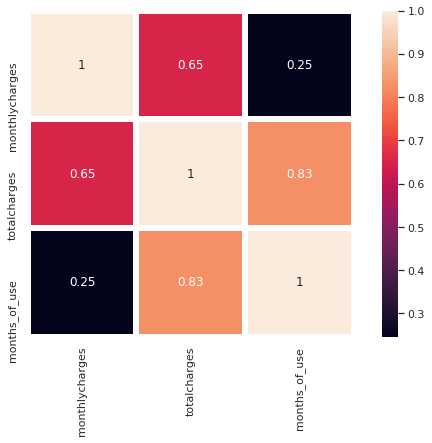

In [49]:
df_corr = df_full.corr()
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.heatmap(df_corr, square=True, linewidths=5, annot=True);

Что вполне ожидаемо, между всеми количественными признаами, коих у нас немного, мы наблюдаем достаточно сильную корреляцию.

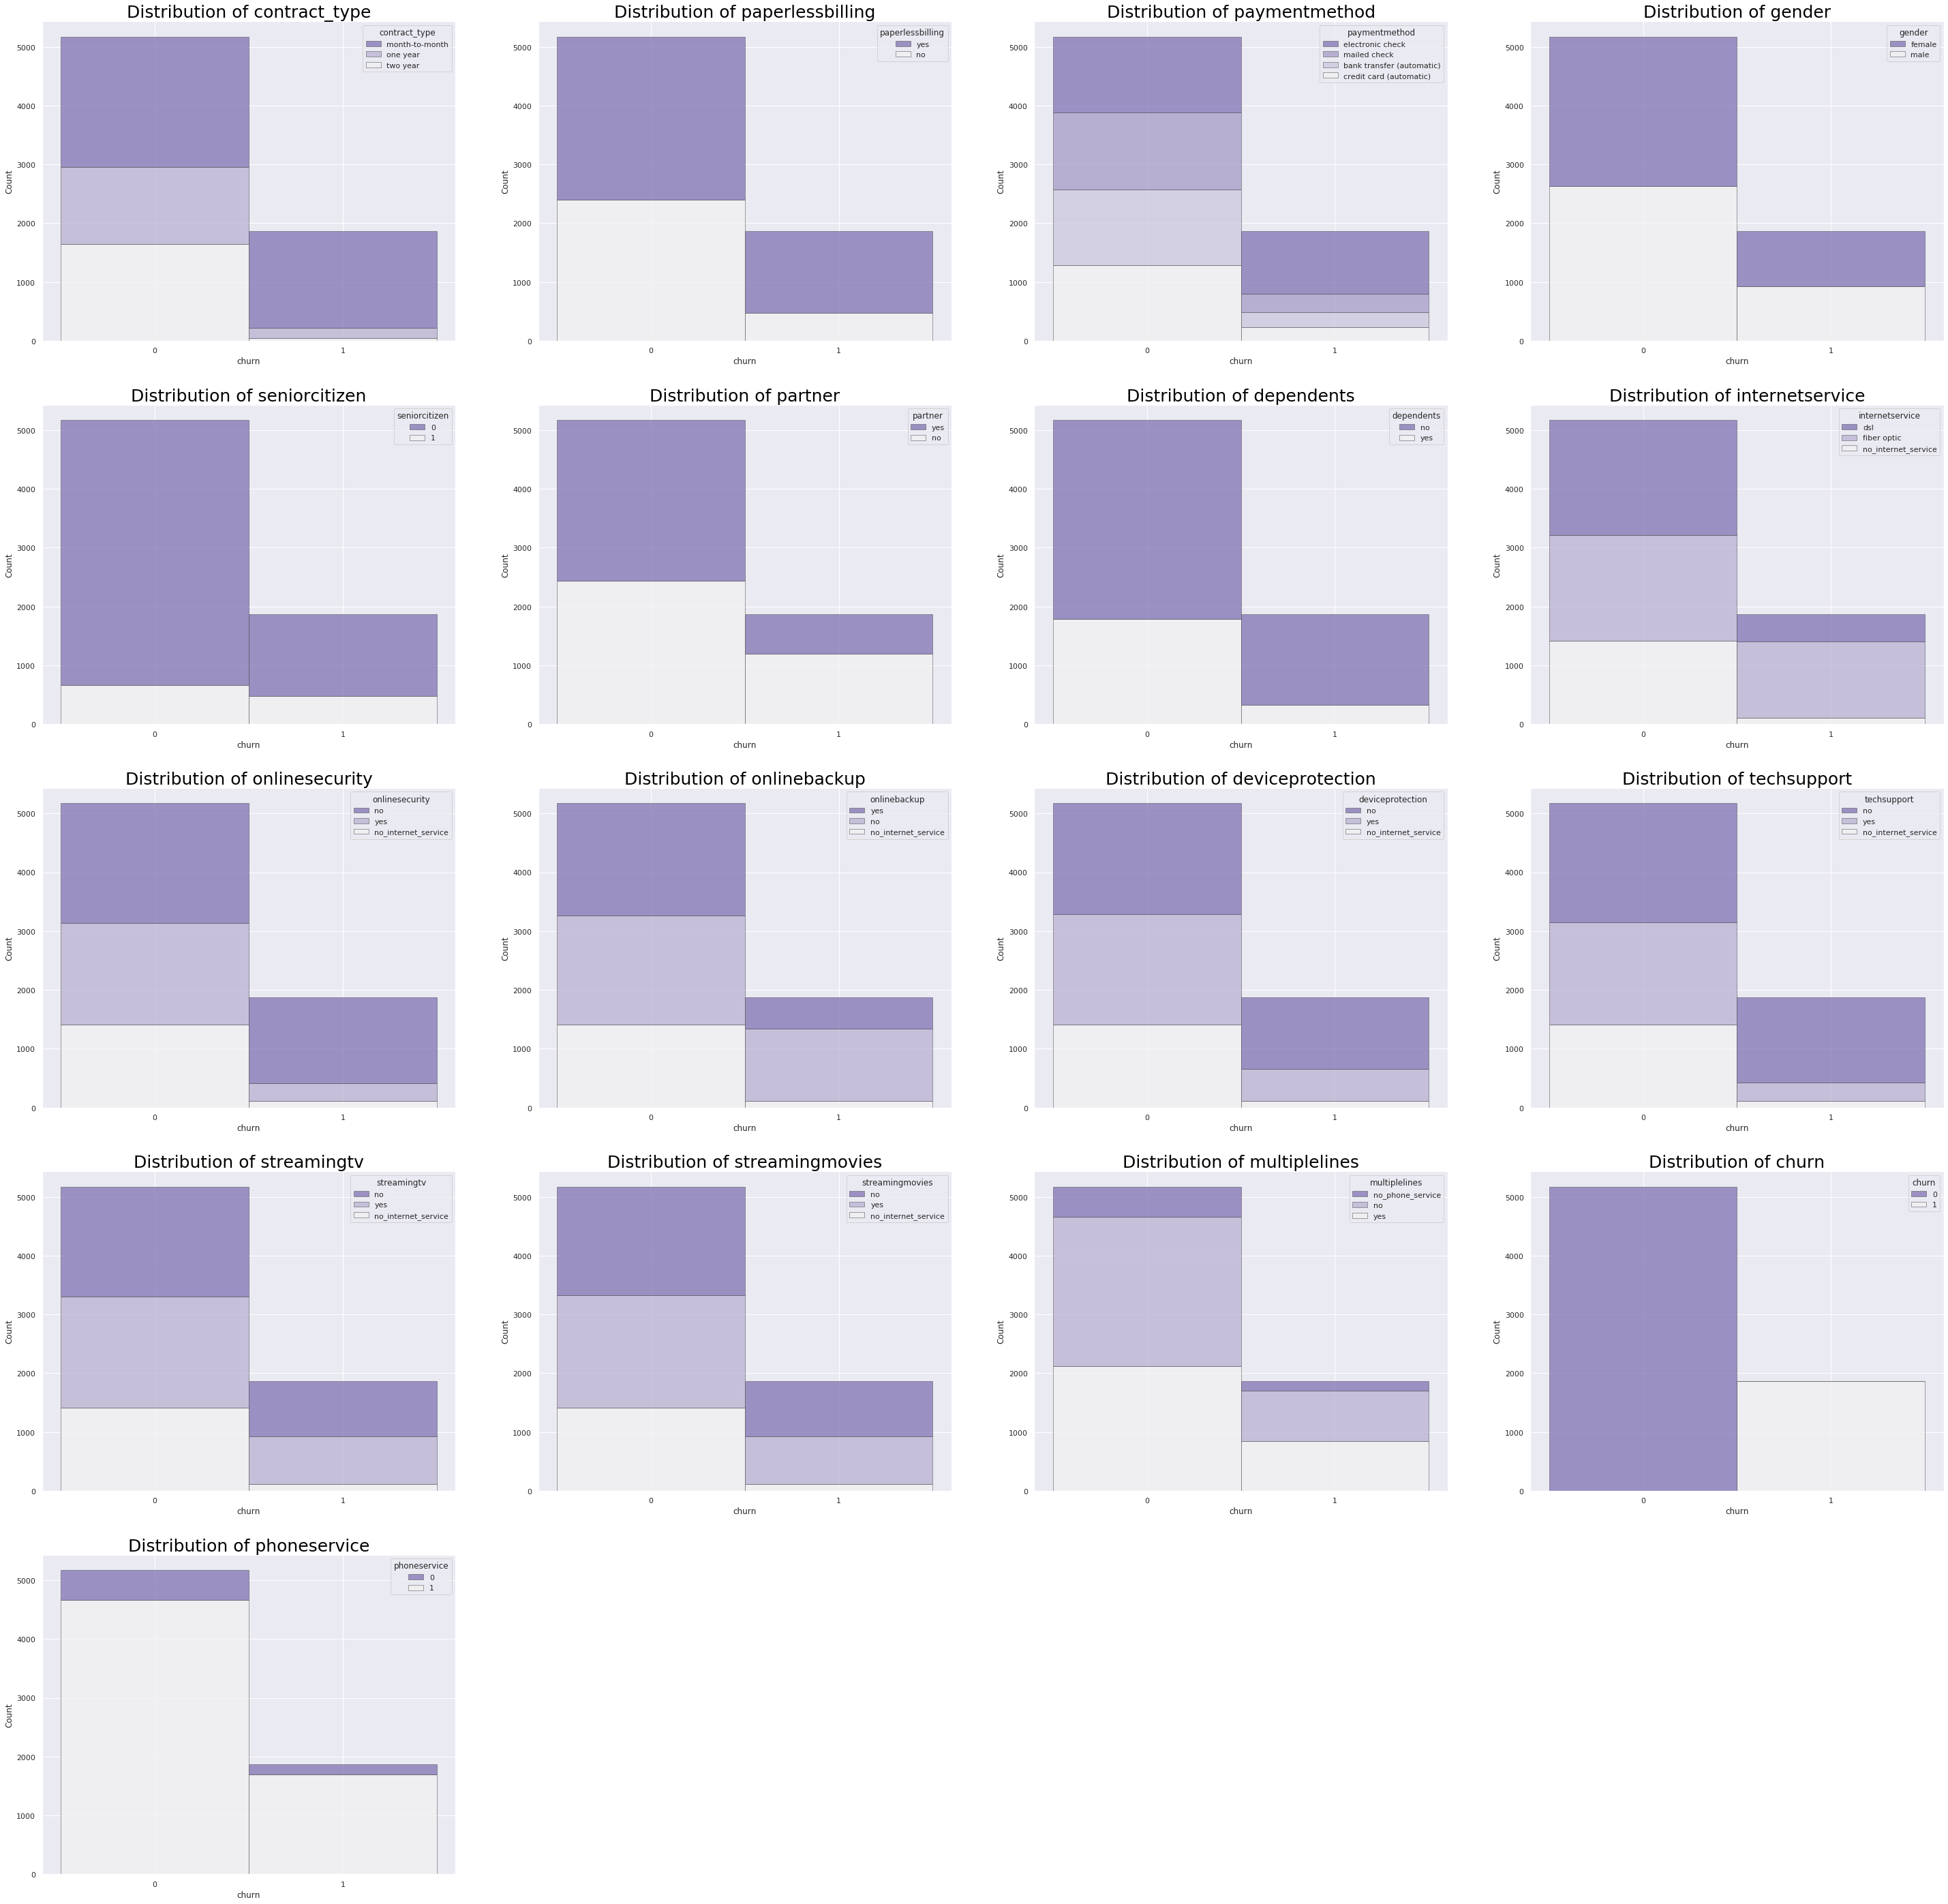

In [50]:
plt.figure(figsize=(50,50))
j = 0
sns.set(style="darkgrid")
for i in categorical_list:
    
    plt.subplot(5,4,j+1)
    sns.histplot(df_full, x = "churn",  hue=df_full[i], multiple="stack", palette="light:m_r", edgecolor=".3", linewidth=.5)
    plt.title(f'Distribution of {i}',color = 'black',fontsize = 25)
    j += 1

На втором этапе мы исследовали наши данные, в основном с применением визуализации для большей наглядности.

В итоге выявлены следующие особенности:

- Обнаружен дисбаланс классов в целевом признаке churn, в частности соотношение оставшиеся/ушедшие примерно 4/1.

- Визуально посмотрели на распределение всех значений признаков, выделив характерные особенности. Среди наиболее выраженных осоебнностей к примеру отметили тот факт, что соотношение количества клиентов, заключавших договоры каждый месяц, и тех, кто готов "серьезно" сотрудничать с нашей компаний, заключив договоры сразу на 1 или 2 года, разнится, первых на порядок больше, в частности их больше половины от всех клиентов. Пользователями интернет-сервисов нашей компании являются около 80% рассматриваемого списка клиентов, из которых большая часть использует оптоволоконный кабель. Таакже большинство клиентов не имеет детей, при этом соотношение клиентов, имеющих партнера и не имеющих примерно одинаковое.
 
- Кроме того, отдельно визуализировали распределение занчений категориальных признаков, сгруппировав по целевому признаку, чтобы посмотреть особенности характеристик ушедших клиентов, так как они нас больше всего интересуют в нашей задаче. Выделили данные особенности.

- Также визуально посмотрели на распределение значений наших количественных признаков, а именно monthlycharges, totalcharges, months_of_use, в том числе с использованием графика boxplot. Так, по количественным признакам ярко выраженных аномальных значений не обнаружено. Между всеми количественными признаками ожидаемо обнаружена достаточно сильная корреляция. Обнаружено, что ушедшие клиенты  в среднем ежемесячно платят больше, чем существующие клиенты.Кроме того, между данными классами существует значительная разница в средних сроках пользования услугами нашей компании и средней общей суммы дохода.

<a id="disbalance"></a>
# 3.Построение модели без учета дисбаланса

Избавляемся от категориальных признаков методом One hot encoder

In [51]:
df_ohe = pd.get_dummies(df_full,prefix_sep = "_", columns = ['contract_type', 'paperlessbilling', 'paymentmethod', 'gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines', 'churn', 'phoneservice'], drop_first=True)

In [52]:
df_ohe

,monthlycharges,totalcharges,months_of_use,contract_type_one year,contract_type_two year,paperlessbilling_yes,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check,gender_male,...,techsupport_no_internet_service,techsupport_yes,streamingtv_no_internet_service,streamingtv_yes,streamingmovies_no_internet_service,streamingmovies_yes,multiplelines_no_phone_service,multiplelines_yes,churn_1,phoneservice_1
0,29.85,29.85,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,56.95,1889.50,34,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
2,53.85,108.15,2,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
3,42.30,1840.75,45,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,70.70,151.65,2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,23,1,0,1,0,0,1,1,...,0,1,0,1,0,1,0,1,0,1
7039,103.20,7362.90,71,1,0,1,1,0,0,0,...,0,0,0,1,0,1,0,1,0,1
7040,29.60,346.45,11,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7041,74.40,306.60,4,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,1,1


In [53]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 31 columns):
monthlycharges                           7043 non-null float64
totalcharges                             7043 non-null float64
months_of_use                            7043 non-null Int64
contract_type_one year                   7043 non-null uint8
contract_type_two year                   7043 non-null uint8
paperlessbilling_yes                     7043 non-null uint8
paymentmethod_credit card (automatic)    7043 non-null uint8
paymentmethod_electronic check           7043 non-null uint8
paymentmethod_mailed check               7043 non-null uint8
gender_male                              7043 non-null uint8
seniorcitizen_1                          7043 non-null uint8
partner_yes                              7043 non-null uint8
dependents_yes                           7043 non-null uint8
internetservice_fiber optic              7043 non-null uint8
internetservice_no_internet_service

подготавливаем целевой и обучающие признаки, делим наш датасет на 3 выборки

In [54]:
features = df_ohe.drop(['churn_1'], axis=1)
target = df_ohe['churn_1']

In [55]:
df_train, df_valid = train_test_split(df_ohe, test_size=0.4, random_state=12345)

In [56]:
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

In [57]:

print('train dataset:', df_train.shape)
print('validation dataset:', df_valid.shape)
print('test dataset:', df_test.shape)


train dataset: (4225, 31)
validation dataset: (1409, 31)
test dataset: (1409, 31)


In [58]:
features_train = df_train.drop('churn_1', axis=1)
target_train = df_train['churn_1']

features_valid = df_valid.drop('churn_1', axis=1)
target_valid = df_valid['churn_1']

features_test = df_test.drop(['churn_1'], axis=1)
target_test = df_test['churn_1']

Стандартизируем выборки 

In [59]:
numeric=['months_of_use', 'monthlycharges', 'totalcharges']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

для поиска оптимальных гиперпараметров используем GridSearchCV

**model DecisionTreeClassifier**

In [60]:
#dtc=DecisionTreeClassifier(random_state=12345)
#param_dtc = { 
#    'max_leaf_nodes': range(2, 21), 
#    'min_samples_split': [2, 3, 4],
#    'max_depth' : range (1,31)}
#
#gs_dtc = GridSearchCV(estimator=dtc, param_grid = param_dtc, cv= 5, scoring = 'roc_auc')
#gs_dtc.fit(features_train, target_train)
#gs_dtc.best_estimator_

In [61]:
dtc_best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
dtc_best.fit(features_train, target_train)
dtc_pred = dtc_best.predict(features_valid)
dtc_result_ac =accuracy_score(target_valid, dtc_pred)
dtc_result_auc = roc_auc_score(target_valid, dtc_best.predict_proba(features_valid)[:, 1])
print('DecisionTreeClassifier best accuracy:', dtc_result_ac)
print('DecisionTreeClassifier best roc_auc:', dtc_result_auc)

DecisionTreeClassifier best accuracy: 0.7977288857345636
DecisionTreeClassifier best roc_auc: 0.8354799981647355


**model RandomForestClassifier**

In [62]:
#rfc=RandomForestClassifier(random_state=12345)
#param_grid = { 
#    'n_estimators':range (1,21),
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : range (1,151,10),
#    'criterion' :['gini', 'entropy']}
#
#
#gs_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring = 'roc_auc')
#gs_rfc.fit(features_train, target_train)
#gs_rfc.best_estimator_

In [63]:
rfc_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False) 
rfc_best.fit(features_train, target_train)
rfc_pred = rfc_best.predict(features_valid)
rfc_result_ac = accuracy_score(target_valid, rfc_pred)
rfc_result_auc = roc_auc_score(target_valid, rfc_best.predict_proba(features_valid)[:, 1])
print('RandomForestClassifier best accuracy:', rfc_result_ac)
print('RandomForestClassifier best roc_auc:', rfc_result_auc)

RandomForestClassifier best accuracy: 0.808374733853797
RandomForestClassifier best roc_auc: 0.8505775985562584


**model LogisticRegression**

In [64]:
#log_reg=LogisticRegression(random_state=12345)
#param_log = {
#    'penalty':['l1', 'l2'],        
#    'solver':['saga'],
#    'C': np.linspace(0.00002,1,100),
#    'max_iter':range(1,21,3)
#}
#
#gs_log = GridSearchCV(estimator=log_reg, param_grid=param_log, cv= 2, verbose = 1, scoring = 'roc_auc')
#gs_log.fit(features_train, target_train)
#gs_log.best_estimator_

In [65]:
log_best=LogisticRegression( C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
log_best.fit(features_train,target_train)
log_predict= log_best.predict(features_valid)
log_result_ac = accuracy_score(target_valid,log_predict)
log_result_auc = roc_auc_score(target_valid, log_best.predict_proba(features_valid)[:, 1])
print("Logistic accuracy score", log_result_ac)
print('Logistic best roc_auc:', log_result_auc)

Logistic accuracy score 0.801277501774308
Logistic best roc_auc: 0.8548815489633304


**model GradientBoostingClassifier**

In [66]:

#model = GradientBoostingClassifier()
#parameters = {
#    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#    "min_samples_split": np.linspace(0.1, 0.5, 12),
#    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#    "max_depth":[3,5,8],
#    "n_estimators":[10]
#                }
#grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2)
#grid.fit(features_train,target_train)    
#print("\n========================================================")
#print(" Результаты Grid Search " )
#print("========================================================")   
#    
#print("\n The best estimator across ALL searched params:\n",
#          grid.best_estimator_)
#    
#print("\n The best score across ALL searched params:\n",
#          grid.best_score_)
#    
#print("\n The best parameters across ALL searched params:\n",
#          grid.best_params_)
#    
#print("\n ========================================================")


In [67]:
grad_best=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

grad_best.fit(features_train,target_train)
grad_predict= grad_best.predict(features_valid)
grad_result_ac= accuracy_score(target_valid,grad_predict)
grad_result_auc = roc_auc_score(target_valid, grad_best.predict_proba(features_valid)[:, 1])
print(" GradientBoostingClassifier accuracy score", grad_result_ac)
print('GradientBoostingClassifier best roc_auc:', grad_result_auc)

 GradientBoostingClassifier accuracy score 0.7913413768630234
GradientBoostingClassifier best roc_auc: 0.8473658854896842


In [68]:
resume_valid={'model':["Дерево решений","Случайный лес","Логистическая регрессия", "Градиентный бустинг"],\
              'roc-auc':[dtc_result_auc,rfc_result_auc,log_result_auc, grad_result_auc]
        ,'accuracy':[dtc_result_ac, rfc_result_ac, log_result_ac, grad_result_ac]}
df_resume_valid = pd.DataFrame(resume_valid)
df_resume_valid

,model,roc-auc,accuracy
0,Дерево решений,0.835480,0.797729
1,Случайный лес,0.850578,0.808375
2,Логистическая регрессия,0.854882,0.801278
3,Градиентный бустинг,0.847366,0.791341


На 3 этапе мы выбирали лучшую модель для последюущего тестирования, при этом дисбаланс классов не учитывали, датасет разделили на 3 выборки, поэтому проверку проводили на валидационной ваборке. Для подбора гиперпараметров использовали инструмент автоматизировнного подбора GridSerchCV. Кроме того, с помощью метода OHE изначально мы закодировали все наши категориальные признаки, а также стандартизировали полученные выборки.

Результы работы моделей представлены выше в виде значений метрик roc-auc и accuracy для валидационной выборки.

Как видим, все модели показали неплохой результат по обоим метрикам, лучший результат у Логистической регрессии и Случайного леса.

<a id="undisbalance on"></a>
# 4.Подготовка модели с учетом дисбаланса

In [69]:
target.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn_1, dtype: float64

Используем технику Upsampling и увеличим количество ушедших клиентов(target==1)¶

In [70]:
def upsampling (features,target,repeat):
    #Разделим выборку по значениям целевой функции
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    #Увеличиваем путем дублирования и соединяем обратно
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    # Перемешиваем
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=1234)
    
    return upsampling_features,upsampling_target

In [71]:
features_balance_up,target_balance_up=upsampling(features_train,target_train,4)

In [72]:
target_balance_up.value_counts(normalize=True)

1    0.585016
0    0.414984
Name: churn_1, dtype: float64

Соотношение классов заметно сбалансировалось, хотя и теперь есть перекос в другую сторону, но все же не такой значительный, как до преобразования.

**model DecisionTreeClassifier**

In [73]:
#dtc_up=DecisionTreeClassifier(random_state=12345)
#param_dtc = { 
#    'max_leaf_nodes': range(2, 21), 
#    'min_samples_split': [2, 3, 4],
#    'max_depth' : range (1,31)}
#
#gs_dtc_up = GridSearchCV(estimator=dtc_up, param_grid = param_dtc, cv= 5, scoring = 'roc_auc')
#gs_dtc_up.fit(features_balance_up, target_balance_up)
#gs_dtc_up.best_estimator_

In [74]:
dtc_best_up = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
dtc_best_up.fit(features_balance_up, target_balance_up)
dtc_pred_up = dtc_best_up.predict(features_valid)
up_dtc_result_ac = accuracy_score(target_valid, dtc_pred_up)
up_dtc_result_auc = roc_auc_score(target_valid, dtc_best_up.predict_proba(features_valid)[:, 1])
print('DecisionTreeClassifier best accuracy:', up_dtc_result_ac)
print('DecisionTreeClassifier best roc_auc:', up_dtc_result_auc)

DecisionTreeClassifier best accuracy: 0.7217885024840313
DecisionTreeClassifier best roc_auc: 0.8382328950789419


In [75]:
#rfc_up=RandomForestClassifier(random_state=12345)
#param_grid = { 
#    'n_estimators':range (1,21),
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : range (1,151,10),
#    'criterion' :['gini', 'entropy']}
#
#
#gs_rfc_up = GridSearchCV(estimator=rfc_up, param_grid=param_grid, cv= 5, scoring = 'roc_auc')
#gs_rfc_up.fit(features_balance_up, target_balance_up)
#gs_rfc_up.best_estimator_

**model RandomForestClassifier**

In [76]:
rfc_best_up = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=21, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False) 
rfc_best_up.fit(features_balance_up, target_balance_up)
rfc_pred_up = rfc_best_up.predict(features_valid)
up_rfc_result_ac = accuracy_score(target_valid, rfc_pred_up)
up_rfc_result_auc = roc_auc_score(target_valid, rfc_best_up.predict_proba(features_valid)[:, 1])
print('RandomForestClassifier best accuracy:', up_rfc_result_ac)
print('RandomForestClassifier best roc_auc:', up_rfc_result_auc)

RandomForestClassifier best accuracy: 0.7955997161107168
RandomForestClassifier best roc_auc: 0.8295893085640583


In [77]:
#log_reg_up=LogisticRegression(random_state=12345)
#param_log = {
#    'penalty':['l1', 'l2'],        
#    'solver':['saga'],
#    'C': np.linspace(0.00002,1,100),
#    'max_iter':range(1,21,3)
#}
#
#gs_log_up = GridSearchCV(estimator=log_reg_up, param_grid=param_log, cv= 3, verbose = 1, scoring = 'roc_auc')
#gs_log_up.fit(features_balance_up, target_balance_up)
#gs_log_up.best_estimator_

**model LogisticRegression**

In [78]:
log_best_up=LogisticRegression( C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
log_best_up.fit(features_balance_up,target_balance_up)
log_predict_up= log_best_up.predict(features_valid)

up_log_result_ac = accuracy_score(target_valid, log_predict_up)
up_log_result_auc = roc_auc_score(target_valid, log_best_up.predict_proba(features_valid)[:, 1])
print("Logistic accuracy score", up_log_result_ac)
print('Logistic best roc_auc:', up_log_result_auc)

Logistic accuracy score 0.7210787792760823
Logistic best roc_auc: 0.8541168553760509


**model GradientBoostingClassifier**

In [79]:
#model = GradientBoostingClassifier()
#parameters = {
#    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#    "min_samples_split": np.linspace(0.1, 0.5, 12),
#    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#    "max_depth":[3,5,8],
#    "n_estimators":[10]
#                }
#grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
#grid.fit(features_balance_up,target_balance_up)    
#
#
#print("\n========================================================")
#print(" Результаты Grid Search " )
#print("========================================================")    
#    
#print("\n The best estimator across ALL searched params:\n",
#          grid.best_estimator_)
#    
#print("\n The best score across ALL searched params:\n",
#          grid.best_score_)
#    
#print("\n The best parameters across ALL searched params:\n",
#          grid.best_params_)
#    
#print("\n ========================================================")

In [80]:
grad_best_up=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.1,
                           min_samples_split=0.390909090909091,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

grad_best_up.fit(features_balance_up,target_balance_up)
grad_predict_up= grad_best_up.predict(features_valid)
up_grad_result_ac = accuracy_score(target_valid, grad_predict_up)
up_grad_result_auc = roc_auc_score(target_valid, grad_best_up.predict_proba(features_valid)[:, 1])

print(" GradientBoostingClassifier accuracy score", up_grad_result_ac)
print('GradientBoostingClassifier best roc_auc:', up_grad_result_auc)

 GradientBoostingClassifier accuracy score 0.7068843151171044
GradientBoostingClassifier best roc_auc: 0.8505291679623976


In [81]:
resume_valid_up={'model':["Дерево решений","Случайный лес","Логистическая регрессия", "Градиентный бустинг"],\
                 'roc-auc':[up_dtc_result_auc,up_rfc_result_auc,up_log_result_auc, up_grad_result_auc]
        ,'accuracy':[up_dtc_result_ac, up_rfc_result_ac, up_log_result_ac, up_grad_result_ac]}
df_resume_valid_up = pd.DataFrame(resume_valid_up)
print('Результаты работы моделей c балансировкой классов')
df_resume_valid_up

Результаты работы моделей c балансировкой классов


,model,roc-auc,accuracy
0,Дерево решений,0.838233,0.721789
1,Случайный лес,0.829589,0.795600
2,Логистическая регрессия,0.854117,0.721079
3,Градиентный бустинг,0.850529,0.706884


In [82]:
print('Результаты работы моделей без балансировки классов')
df_resume_valid

Результаты работы моделей без балансировки классов


,model,roc-auc,accuracy
0,Дерево решений,0.835480,0.797729
1,Случайный лес,0.850578,0.808375
2,Логистическая регрессия,0.854882,0.801278
3,Градиентный бустинг,0.847366,0.791341


На 4 этапе мы выполняли аналогичные манипуляции с нашими данными, что на 3 этапе, однако уже с учетом дисбаланса классов, для борьбы с которым использована техника Upsampling, в частности увеличено количество ушедших клиентов(target==1).

Результаты работы моделей с учетом дисбаланса указаны выше.

Как видно, балансировка классов не лучшим образом сказалась на такой метрике, как точнсть,¶при этом по метрике roc-auc существенных отличий в результатах нет, за исключением случайного леса, в модели с применением балансировки классов результат получился немного лучше.

<a id="auc-roc"></a>
# 5. Тестирование моделей.

Протестируем наши модели на тестовой выборке. Также для каждой модели отобразим матрицы ошибок и опеределим наиболее важные признаки. Для тестирования будем использовать модели, созданные без учета дисбаланса, так как значение метрики accuracy по результатам работы данных моделей существенно выше, чем у моделей, построенных с использованием балансировки классов.

In [83]:
%%time
dtc_best_test = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
dtc_best_test.fit(features_train, target_train)
dtc_pred_test = dtc_best_test.predict(features_test)
dtc_result_accuracy =  accuracy_score(target_test, dtc_pred_test)
dtc_result_roc_auc = roc_auc_score(target_test, dtc_best_test.predict_proba(features_test)[:, 1])
print('Лучшая модель дерева решений', 'Accuracy:', dtc_result_accuracy, 'roc-auc:', dtc_result_roc_auc)

Лучшая модель дерева решений Accuracy: 0.7927608232789212 roc-auc: 0.8191681987854477
CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 20.4 ms


Accuracy: 0.7927608232789212

Confussion matrix DecisionTreeClassifier: 
[[955 224]
 [ 68 162]]



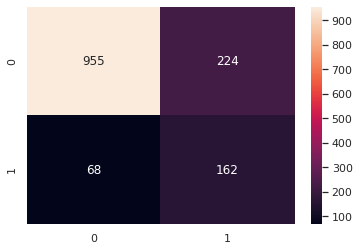

In [84]:
conf_matrix_dtc = confusion_matrix(dtc_pred_test, target_test)

print(f'Accuracy: {accuracy_score(dtc_pred_test, target_test)}')
print()
print(f'Confussion matrix DecisionTreeClassifier: \n{conf_matrix_dtc}\n')

sns.heatmap(conf_matrix_dtc, annot=True, fmt = 'd');

In [85]:
print(classification_report(dtc_pred_test, target_test))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1179
           1       0.42      0.70      0.53       230

    accuracy                           0.79      1409
   macro avg       0.68      0.76      0.70      1409
weighted avg       0.85      0.79      0.81      1409



Посмотрим также на важность каждого признака, которые позволяют увидеть связь каждого признака с целью прогнозирования.

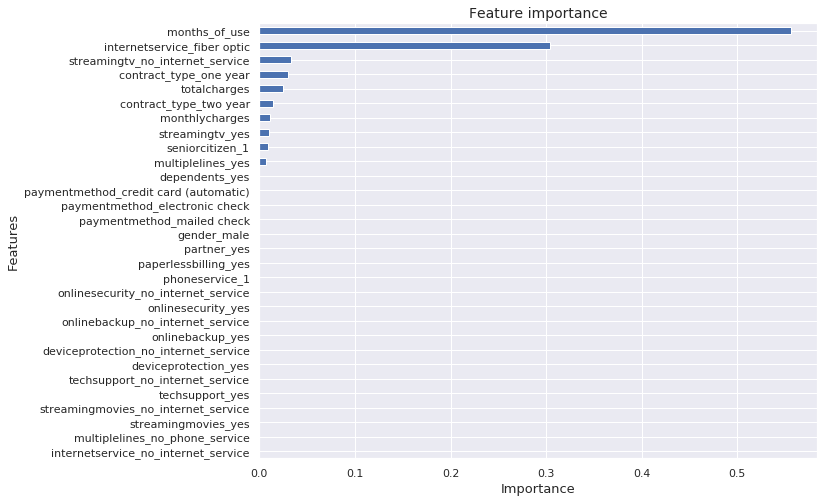

In [86]:
feature_importance = pd.Series(dtc_best_test.feature_importances_, features_train.columns)
plt.figure(figsize = (10,8))
feature_importance.sort_values().plot(kind = 'barh')
plt.xlabel("Importance", fontsize = 13)
plt.ylabel("Features", fontsize = 13)
plt.title("Feature importance", fontsize = 14);

In [87]:
%%time
log_best_test=LogisticRegression( C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
log_best_test.fit(features_train,target_train)
log_predict_test= log_best_test.predict(features_test)

log_result_accuracy =  accuracy_score(target_test,log_predict_test)
log_result_roc_auc =  roc_auc_score(target_test, log_best_test.predict_proba(features_test)[:, 1])
print('Лучшая модель логистической регрессии', 'Accuracy:', log_result_accuracy, 'roc-auc:', log_result_roc_auc)

Лучшая модель логистической регрессии Accuracy: 0.7963094393186657 roc-auc: 0.8247509357320488
CPU times: user 88.7 ms, sys: 69.2 ms, total: 158 ms
Wall time: 96.8 ms


Accuracy: 0.7963094393186657

Confussion matrix LogisticRegression: 
[[917 181]
 [106 205]]



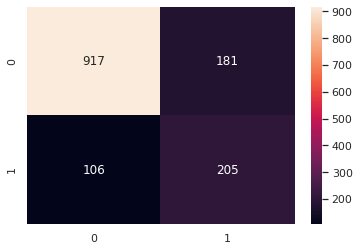

In [88]:

conf_matrix_log = confusion_matrix(log_predict_test, target_test)

print(f'Accuracy: {accuracy_score(log_predict_test, target_test)}')
print()
print(f'Confussion matrix LogisticRegression: \n{conf_matrix_log}\n')

sns.heatmap(conf_matrix_log, annot=True, fmt = 'd');

In [89]:
print(classification_report(log_predict_test, target_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.86      1098
           1       0.53      0.66      0.59       311

    accuracy                           0.80      1409
   macro avg       0.71      0.75      0.73      1409
weighted avg       0.82      0.80      0.80      1409



In [90]:
%%time
rfc_best_test = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False) 
rfc_best_test.fit(features_train, target_train)
rfc_pred_test = rfc_best_test.predict(features_test)
rfc_result_accuracy =  accuracy_score(target_test, rfc_pred_test)
rfc_result_roc_auc = roc_auc_score(target_test, rfc_best_test.predict_proba(features_test)[:, 1])
print('Лучшая модель дерева решений', 'Accuracy:', rfc_result_accuracy, 'roc-auc:', rfc_result_roc_auc)

Лучшая модель дерева решений Accuracy: 0.7991483321504613 roc-auc: 0.8190770313869093
CPU times: user 128 ms, sys: 3.92 ms, total: 132 ms
Wall time: 146 ms


Accuracy: 0.7991483321504613

Confussion matrix RandomForestClassifier: 
[[937 197]
 [ 86 189]]



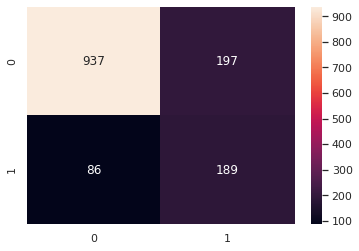

In [91]:
conf_matrix_rfc = confusion_matrix(rfc_pred_test, target_test)

print(f'Accuracy: {accuracy_score(rfc_pred_test, target_test)}')
print()
print(f'Confussion matrix RandomForestClassifier: \n{conf_matrix_rfc}\n')

sns.heatmap(conf_matrix_rfc, annot=True, fmt = 'd');

In [92]:
print(classification_report(rfc_pred_test, target_test))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1134
           1       0.49      0.69      0.57       275

    accuracy                           0.80      1409
   macro avg       0.70      0.76      0.72      1409
weighted avg       0.83      0.80      0.81      1409



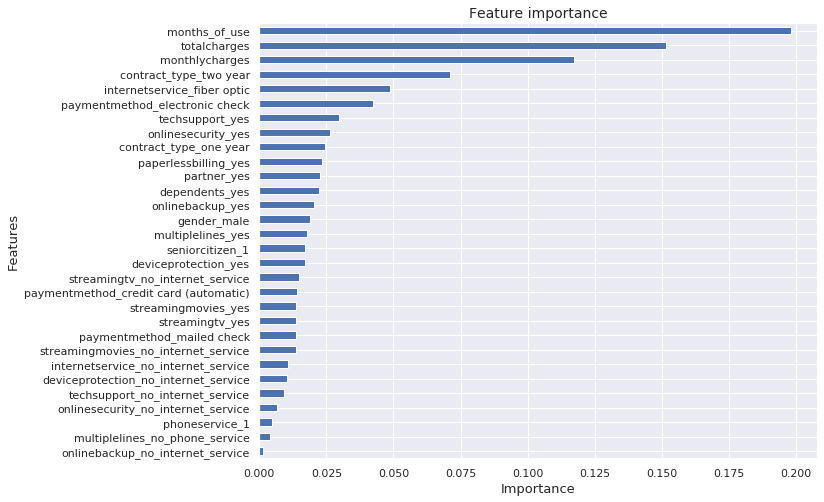

In [93]:
feature_importance = pd.Series(rfc_best_test.feature_importances_, features_train.columns)
plt.figure(figsize = (10,8))
feature_importance.sort_values().plot(kind = 'barh')
plt.xlabel("Importance", fontsize = 13)
plt.ylabel("Features", fontsize = 13)
plt.title("Feature importance", fontsize = 14);

In [94]:
%%time
grad_best_test=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

grad_best_test.fit(features_train,target_train)
grad_predict_test= grad_best_test.predict(features_test)

grad_result_accuracy =  accuracy_score(target_test,grad_predict_test)
grad_result_roc_auc = roc_auc_score(target_test, grad_best_test.predict_proba(features_test)[:, 1])
print('Лучшая модель градиентного бустинга', 'Accuracy:', grad_result_accuracy, 'roc-auc:', grad_result_roc_auc)

Лучшая модель градиентного бустинга Accuracy: 0.7842441447835344 roc-auc: 0.8222982794685954
CPU times: user 84.4 ms, sys: 0 ns, total: 84.4 ms
Wall time: 98.2 ms


Accuracy: 0.7842441447835344

Confussion matrix GradientBoostingClassifier: 
[[950 231]
 [ 73 155]]



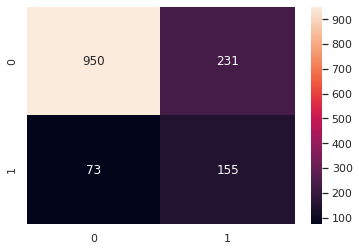

In [95]:
conf_matrix_grad = confusion_matrix(grad_predict_test, target_test)

print(f'Accuracy: {accuracy_score(grad_predict_test, target_test)}')
print()
print(f'Confussion matrix GradientBoostingClassifier: \n{conf_matrix_grad}\n')

sns.heatmap(conf_matrix_grad, annot=True, fmt = 'd');

In [96]:
print(classification_report(grad_predict_test, target_test))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1181
           1       0.40      0.68      0.50       228

    accuracy                           0.78      1409
   macro avg       0.67      0.74      0.68      1409
weighted avg       0.84      0.78      0.80      1409



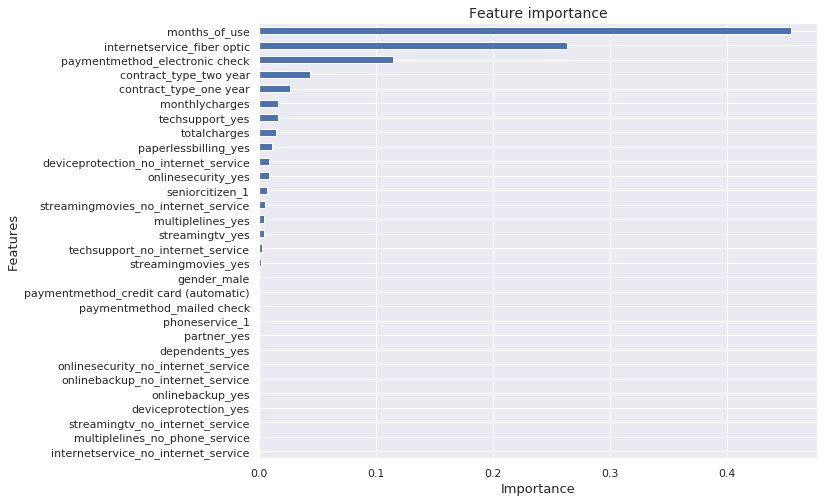

In [97]:
feature_importance = pd.Series(grad_best_test.feature_importances_, features_train.columns)
plt.figure(figsize = (10,8))
feature_importance.sort_values().plot(kind = 'barh')
plt.xlabel("Importance", fontsize = 13)
plt.ylabel("Features", fontsize = 13)
plt.title("Feature importance", fontsize = 14);

Как видим, наиболее важным признаком для прогнозирования оттока является признак с указанием срока пользования услугами нашей компании. Также важными признаками являются: тип интернет-сервиса, в частности способ обеспечения интернет-связи, тип контракта, способ оплаты, сумма дохода.

In [98]:
fpr_tree,tpr_tree,thresholds=roc_curve(target_test, dtc_best_test.predict_proba(features_test)[:, 1])

In [99]:
fpr_logistic,tpr_logistic,thresholds=roc_curve(target_test, log_best_test.predict_proba(features_test)[:, 1])

In [100]:
fpr_forest,tpr_forest,thresholds=roc_curve(target_test, rfc_best_test.predict_proba(features_test)[:, 1])

In [101]:
fpr_gbs,tpr_gbs,thresholds=roc_curve(target_test, grad_best_test.predict_proba(features_test)[:, 1])

отображаем roc-кривые на графике, чтобы наглядно видеть, как сильно модель отличается от случайной.

<Figure size 432x288 with 0 Axes>

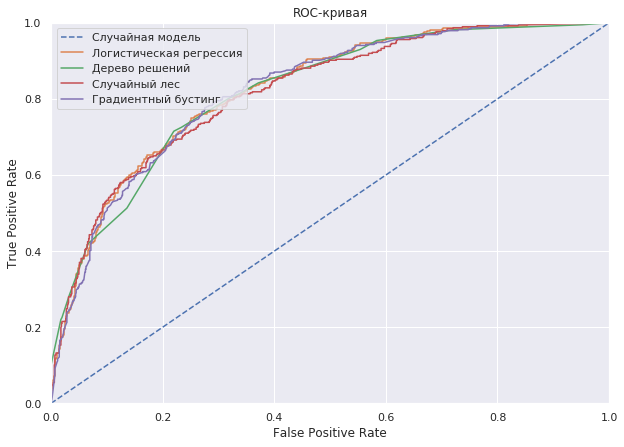

In [102]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_logistic,tpr_logistic)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.plot(fpr_gbs,tpr_gbs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Логистическая регрессия','Дерево решений','Случайный лес', 'Градиентный бустинг'),
           loc= 'upper left')
plt.show();

На графике, как и по занчениям метрики roc-auc, видим, что площадь между roc-кривыми наших моделей и случайной модели примерное одинаковая для всех рассмотренных моделей. Результат далек от идеального, но все же показывает, что модели достаточно качественно различают классы целевого признака.

In [103]:
resume={'model':["Дерево решений","Случайный лес","Логистическая регрессия",\
                 "Градиентный бустинг"],'roc-auc':[dtc_result_roc_auc,rfc_result_roc_auc,log_result_roc_auc,\
                                                   grad_result_roc_auc]
        ,'accuracy':[dtc_result_accuracy, rfc_result_accuracy, log_result_accuracy, grad_result_accuracy]}
df_resume = pd.DataFrame(resume)
print('Результаты тестирования моделей')
df_resume

Результаты тестирования моделей


,model,roc-auc,accuracy
0,Дерево решений,0.819168,0.792761
1,Случайный лес,0.819077,0.799148
2,Логистическая регрессия,0.824751,0.796309
3,Градиентный бустинг,0.822298,0.784244


Исходя из полученных значений метрик, в особенности roc-auc, лучшие модели - логистическая регрессия и градиентный бустинг. На матрицах ошибок мы видим, что логистическая регрессия наиболее точно из всех моделей определяет ушедших клиентов как действительно ушедших среди всех клиентов. Однако по метрике полноты, логистическая регрессия уступает другим моделям, тут лучший результат у дерева решений, то есть эта модель наиболее полно выделяет ушедших клиентов среди всех ушедших клиентов.  Вместе с тем, в целом все модели показали практически одинаковый результат, поэтому можем использовать любую из них.

<a id="predict"></a>
# 6. Прогнозирование оттока действующих клиентов

Так как мы создали модель, взяв за основу ушедших и действующих клиентов, то сейчас мы можем использовать ту же модель для определения вероятности оттока средди действующих клиентов. Провдем эксперимент, использововав модель градиентного бустинга.

In [104]:
current_clients = df_ohe[df_ohe['churn_1']==0]
current_clients_features = current_clients.drop(['churn_1'], axis=1)
current_clients_target = current_clients['churn_1']

In [105]:
current_clients_churn_prob = grad_best_test.predict_proba(current_clients_features)

In [106]:
current_clients['churn_proba'] = current_clients_churn_prob[:][:,1]

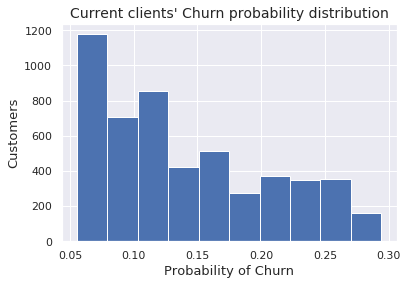

In [107]:
plt.hist(current_clients['churn_proba']
         , bins = 10)

plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)
plt.title("Current clients' Churn probability distribution", fontsize=14);

In [108]:
current_clients.loc[(current_clients['churn_proba'] >= 0.8) , 'risk_type'] = 'very high'
current_clients.loc[(current_clients['churn_proba'] >= 0.6) & (current_clients['churn_proba'] < 0.8)  ,\
                    'risk_type'] = 'high'
current_clients.loc[(current_clients['churn_proba'] >= 0.4) & (current_clients['churn_proba'] < 0.6) , \
                    'risk_type'] = 'medium'
current_clients.loc[(current_clients['churn_proba'] >= 0.2) & (current_clients['churn_proba'] < 0.4) , \
                    'risk_type'] = 'low'
current_clients.loc[(current_clients['churn_proba'] > 0.0) & (current_clients['churn_proba'] < 0.2) ,\
                    'risk_type'] = 'very low'

In [109]:
print(np.min(current_clients['churn_proba']))

0.05547738442869201


In [110]:
print(np.max(current_clients['churn_proba']))

0.2942408267466042


In [111]:
current_clients['risk_type'].value_counts()

very low    3942
low         1232
Name: risk_type, dtype: int64

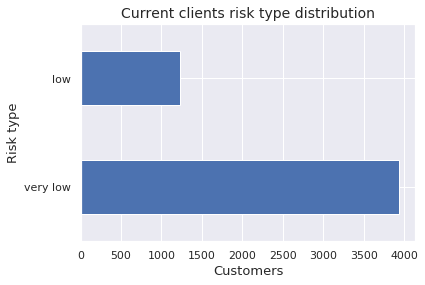

In [112]:
current_clients['risk_type'].value_counts().plot(kind = 'barh')
plt.title("Current clients risk type distribution", fontsize=14)
plt.ylabel("Risk type", fontsize = 13)
plt.xlabel("Customers", fontsize = 13);

In [113]:
current_clients[current_clients['risk_type']=='low']


,monthlycharges,totalcharges,months_of_use,contract_type_one year,contract_type_two year,paperlessbilling_yes,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check,gender_male,...,streamingtv_no_internet_service,streamingtv_yes,streamingmovies_no_internet_service,streamingmovies_yes,multiplelines_no_phone_service,multiplelines_yes,churn_1,phoneservice_1,churn_proba,risk_type
0,29.85,29.85,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0.200521,low
6,89.10,1949.40,22,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0.261576,low
12,100.35,5681.10,58,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0.201793,low
14,105.50,2686.05,25,0,0,1,0,1,0,1,...,0,1,0,1,0,0,0,1,0.219816,low
19,90.05,1862.90,21,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0.253314,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7025,95.05,1679.40,18,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0.223410,low
7029,44.40,263.05,6,0,0,1,0,1,0,0,...,0,1,0,1,1,0,0,0,0.206089,low
7033,69.50,2625.25,38,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0.229780,low
7035,78.70,1495.10,19,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0.246738,low


Теперь, с помощью полученных моделей мы можем группировать клиентов по уровню риска оттока и, соответственно, мы можем разработать план удержания для каждой целевой группы.

<a id="conclusion"></a>
# Вывод.

В ходе выполнения проекта выполнены нижеследующие шаги, в ходе выполнения которых достигнуты следующие результаты.

**На первом этапе** мы посмотрели на наши исходные данные и подготовили их для дальнейшего исследования. Так, в частности, произведеные следующие действия:

- Для удобства дальнейшей работы с данными полученные 4 датасета, содержащие информацию о наших клиентах и их характеристиках, объединены в один датасет методом merge.

- Обнаружены проблемы с тимпами данных некоторых признаков, а именно totalcharges, даты начала и окончания действия договора с клиентом. Данные проблемы решены путем замены типа данных указанных признаков, при этом в признаке totalcharges также обнаружены строки с пустыми занчениями, которые заменены сумму общего дохода от клиента в зависимости от количества месяцев пользования и суммы месячного платежа.

- После объединения датасетов возникли пропущенные значения, которые заменены соответствующее числовое либо текстовое значение, указывающее на факт отсутствия той или иной услуги у клиента.

- Все значения столбцов, в том числе и названия столбцов, приведены к нижнему регистру во избежание проблем, связанных с опечатками.

- Созданы новые признаки, а именно признак (целевой) оттока клиентов churn, признак months_of_use, указывающий на количество месяцев пользования услугами нашей компании конкретным клиентом, а также признаки phoneservice и internetservice, указывающие на факт наличия либо отсутствия данных услуг у клиента.

- Удалены следующие признаки: 'customerid', 'begindate', 'enddate'. Первый признак удален, так как его необходимость для качественного обучения модели маловероятна, а последние 2 признака удалены, чтобы избежать утечки целевого признака.

**На втором** этапе мы исследовали наши данные, в основном с применением визуализации для большей наглядности.

В итоге выявлены следующие особенности:

- Обнаружен дисбаланс классов в целевом признаке churn, в частности соотношение оставшиеся/ушедшие примерно 4/1.

- Визуально посмотрели на распределение всех значений признаков, выделив характерные особенности. Среди наиболее выраженных осоебнностей к примеру отметили тот факт, что соотношение количества клиентов, заключавших договоры каждый месяц, и тех, кто готов "серьезно" сотрудничать с нашей компаний, заключив договоры сразу на 1 или 2 года, разнится, первых на порядок больше, в частности их больше половины от всех клиентов. Пользователями интернет-сервисов нашей компании являются около 80% рассматриваемого списка клиентов, из которых большая часть использует оптоволоконный кабель. Таакже большинство клиентов не имеет детей, при этом соотношение клиентов, имеющих партнера и не имеющих примерно одинаковое.
 
- Кроме того, отдельно визуализировали распределение занчений категориальных признаков, сгруппировав по целевому признаку, чтобы посмотреть особенности характеристик ушедших клиентов, так как они нас больше всего интересуют в нашей задаче. Выделили данные особенности.

- Также визуально посмотрели на распределение значений наших количественных признаков, а именно monthlycharges, totalcharges, months_of_use, в том числе с использованием графика boxplot. Так, по количественным признакам ярко выраженных аномальных значений не обнаружено. Между всеми количественными признаками ожидаемо обнаружена достаточно сильная корреляция. Обнаружено, что ушедшие клиенты  в среднем ежемесячно платят больше, чем существующие клиенты.Кроме того, между данными классами существует значительная разница в средних сроках пользования услугами нашей компании и средней общей суммы дохода.

**На 3 этапе** мы выбирали лучшую модель для последюущего тестирования, при этом дисбаланс классов не учитывали, датасет разделили на 3 выборки, поэтому проверку проводили на валидационной ваборке. Для подбора гиперпараметров использовали инструмент автоматизировнного подбора GridSerchCV. Кроме того, с помощью метода OHE изначально мы закодировали все наши категориальные признаки, а также стандартизировали полученные выборки. В работе проводились эксперименты со следующими моделями: Дерево решений, Случайный лес, Логистическая регрессия, Градиентный бустинг.

В результате, все модели показали неплохой результат по обоим интересующим метрикам, а именно accuracy и roc-auc, при этом лучший результат у Логистической регрессии и Случайного леса.

**На 4 этапе** мы выполняли аналогичные манипуляции с нашими данными, что на 3 этапе, однако уже с учетом дисбаланса классов, для борьбы с которым использована техника Upsampling, в частности увеличено количество ушедших клиентов(target==1).

В результате установлено, что балансировка классов не лучшим образом сказалась на такой метрике, как точность (accuracy),¶при этом по метрике roc-auc существенных отличий в результатах нет, за исключением случайного леса, в модели с применением балансировки классов результат получился немного лучше.

**На пятом этапе** полученные модели тестировались на тестовой выборке. Также для каждой модели отображены матрицы ошибок и опеределены наиболее важные признаки, в том числе для наглядности визуально отображены roc-кривые тестируемых моделей. Для тестирования использованы модели, созданные без учета дисбаланса, так как значение метрики accuracy по результатам работы данных моделей существенно выше, чем у моделей, построенных с использованием балансировки классов.

Исходя из полученных значений метрик, в особенности roc-auc, лучшие модели - логистическая регрессия  (roc-auc =0.824)и Градиентный бустинг (roc-auc =0,822.). На матрицах ошибок обнуражено, что логистическая регрессия наиболее точно из всех моделей определяет ушедших клиентов как действительно ушедших среди всех клиентов. Однако по метрике полноты логистическая регрессия уступает другим моделям, тут лучший результат у дерева решений, то есть эта модель наиболее полно выделяет ушедших клиентов среди всех ушедших клиентов.  Вместе с тем, в целом все модели показали практически одинаковый результат, поэтому можем использовать любую из них.

**На заключительном 6 этапе** мы производили эксперимент с применинем одной из полученных моделей, в частности Градиентный бустинг, при прогнозирования оттока клиентов среди действующих клиентов, сгруппировав предсказанных к уходу клиентов по уровню риска оттока. В результате, с помощью полученных моделей мы можем группировать клиентов по уровню риска оттока и, соответственно, мы можем разработать план удержания для каждой целевой группы.

<a id="report"></a>
# Отчет о проделанной работе.

1. В ходе выполнения работы выполнены практически все пункты плана, за исключением последнего, в частности было принято решение в данной работе не касаться выдвижения рекомендаций для борьбы с оттоком клиентов, так как цель, а именно определение оттока клиентов, достигнута, при этом составление рекомендаций по борьбе с оттоком оставим для отдельного исследования, которое целесообразно проводить при взаимодействии с маркетолагами нашей компании. Также при выполнении работы не применялась запланированная к проведению кроссвалидация, так как ее проведение никаким образом не улучшило конечный результат.

2. В ходе работы  возникали трудности с правильностью выполнения кода, которые преодолевались с помощью ознакомления с решениями подобных проблем на специализированных форумах. В части непосредственных трудностей при подготовке моделей выделена такая проблема, как дисбаланс классов целевого признака, которая решена путем применения метода Upsampling. 

3. В ходе выполнения проекта выделены пройдены следующие ключевые шаги:

*Загрузка и подготовка данных.

*Исследование данных.

*Построение модели без учета дисбаланса классов.

*Построение модели с учетом дисбаланса классов.

*Финальное тестирование.

*Прогнозирование оттока действующих клиентов.

*Общий вывод по результатам работы.

4. Исходя из полученных значений интересующих метрик, в особенности roc-auc, лучшие модели - логистическая регрессия (roc-auc = 0.824) и Градиентный бустинг (roc-auc =0.822).